<a href="https://colab.research.google.com/github/HST0077/HYOTC/blob/main/copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3차원 그래프**

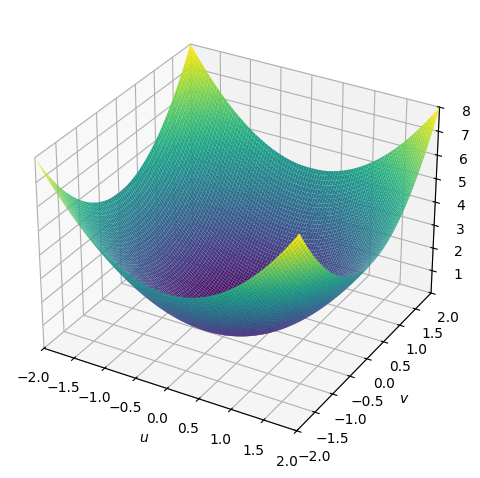

In [ ]:
import sympy as smp

u,v = smp.symbols('u v')
smp.plotting.plot3d(u**2+v**2, (u,-2,2), (v,-2,2))

In [ ]:
# interactive mode, plotly 패키지 사용
import plotly.graph_objects as go
import numpy as np

u = np.linspace(-2, 2, 100)
v = np.linspace(-2, 2, 100)
U, V = np.meshgrid(u, v)
Z = U**2 + V**2

fig = go.Figure(data=[go.Surface(z=Z, x=U, y=V)])
fig.show()

# **2변량 정규분포의 pdf 그려보기**

In [ ]:
# multivariate normal random samples by scipy
import numpy as np
from scipy.stats import multivariate_normal

# 평균벡터 & 공분산행렬
mean = [0, 0, 0]
cov  = [[1, -0.2, -0.3],
        [-0.2, 1, 0.9],
        [-0.3, 0.9, 1]]

# scipy.stats.multivariate_normal 객체 생성
rv = multivariate_normal(mean=mean, cov=cov)

# x1, x2 격자 생성 (세 번째 변수 x3는 0으로 고정)
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# x3 = 0으로 고정된 평면
X3 = np.zeros_like(X1)

# (x1, x2, x3=0) 점들을 하나의 배열로 쌓기
# scipy.stats.multivariate_normal.pdf는 (..., 3) 형태도 받아줌
pos = np.stack((X1, X2, X3), axis=-1)   # shape: (100, 100, 3)

# 각 점에서의 pdf 값 계산
Z = rv.pdf(pos)  # shape: (100, 100)

# Plotly로 3D surface plot
fig = go.Figure(data=[
    go.Surface(
        x=X1,
        y=X2,
        z=Z,
        # colorscale="Viridis"  # 원하면 색상도 지정 가능
    )
])

fig.update_layout(
    title="3D PDF slice: f(x1, x2, x3=0)",
    scene=dict(
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="pdf(x1, x2, x3=0)"
    ),
    template="plotly_white"
)

fig.show()

# X,Y는 서로 0.5의 상관관계를 갖고 있고, X는 평균이 2인 포아송분포, Y는 평균 1, 표준편차 3인 정규분포를 따른다고 할 때, 1000쌍의 난수 쌍을 만들어어라.

matplotlib이 인식한 폰트 이름: NanumGothic
현재 설정된 폰트 패밀리: ['NanumGothic']


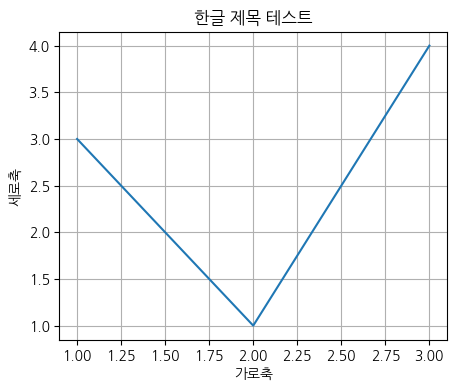

In [ ]:
# 그래프 한글 출력 보완
# 1) 폰트 캐시 삭제 (이전 설정 깨끗이)
!rm -rf ~/.cache/matplotlib

# 2) 나눔고딕 TTF 파일 다운로드
!wget -q -O /content/NanumGothic.ttf \
  "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 3) 폰트를 matplotlib fontManager에 등록
font_path = "/content/NanumGothic.ttf"
fm.fontManager.addfont(font_path)                 # ⭐ 이게 핵심
font_name = fm.FontProperties(fname=font_path).get_name()
print("matplotlib이 인식한 폰트 이름:", font_name)

# 4) 전역 설정
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

print("현재 설정된 폰트 패밀리:", mpl.rcParams['font.family'])

# 5) 테스트 플롯
plt.figure(figsize=(5,4))
plt.plot([1,2,3], [3,1,4])
plt.title("한글 제목 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.grid(True)
plt.show()


     X         Y
0  2.0  0.717101
1  2.0 -0.493758
2  3.0 -0.919089
3  2.0 -0.493101
4  2.0  2.335260

===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.451585
Y  0.451585  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.441481
Y  0.441481  1.000000


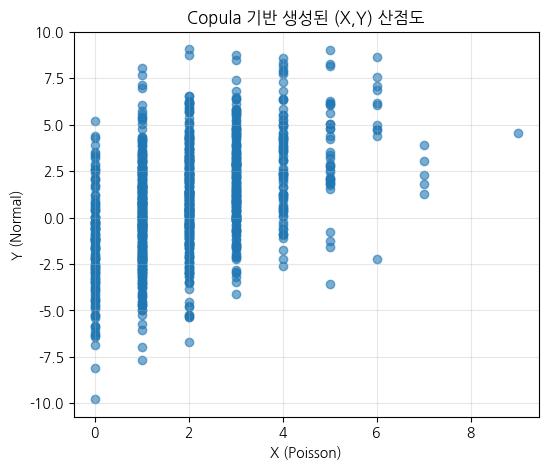

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# 1. Copula 기반 난수 생성 설정
# -------------------------------------------------------
n = 1000                 # 샘플 수
rho = 0.5                # 목표 상관관계
mean_poisson = 2         # X ~ Poisson(2)
mu_y = 1                 # Y ~ Normal(1, 3)
sigma_y = 3

# -------------------------------------------------------
# 2. Gaussian Copula 샘플 생성
#    1) 상관 구조를 가진 정규쌍 (Z1, Z2) 생성
#    2) 각 변수를 CDF → Uniform(0,1)
#    3) Uniform을 각각 Poisson, Normal의 역변환을 적용
# -------------------------------------------------------

# 2-1. 상관행렬
cov = [[1, rho],
       [rho, 1]]

# 다변량 정규(표준정규)에서 1000쌍 생성
Z = np.random.multivariate_normal([0,0], cov, size=n)
Z1, Z2 = Z[:,0], Z[:,1]

# 2-2. CDF로 변환 → U1, U2 ~ Uniform(0,1)
U1 = st.norm.cdf(Z1)
U2 = st.norm.cdf(Z2)

# 2-3. 각 분포의 inverse CDF를 적용 (Copula 변환)
X = st.poisson.ppf(U1, mean_poisson)        # 포아송 역변환
Y = mu_y + sigma_y * st.norm.ppf(U2)        # 정규 역변환

# -------------------------------------------------------
# 3. 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
print(df.head())

# -------------------------------------------------------
# 4. 상관관계 검증 (피어슨, 스피어만)
# -------------------------------------------------------
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")

print("\n===== 상관관계(피어슨) =====")
print(pear_corr)

print("\n===== 상관관계(스피어만) =====")
print(spear_corr)

# -------------------------------------------------------
# 5. 시각화 (산점도)
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(X, Y, alpha=0.6)
plt.title("Copula 기반 생성된 (X,Y) 산점도")
plt.xlabel("X (Poisson)")
plt.ylabel("Y (Normal)")
plt.grid(alpha=0.3)
plt.show()

In [5]:
# statsmodels 패키지 이용

import numpy as np
import pandas as pd
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import GaussianCopula

# -----------------------------
# 1) Gaussian copula 설정
# -----------------------------
rho = 0.5
corr = np.array([[1.0, rho],
                 [rho, 1.0]])

# 상관계수 행렬을 사용
cop = GaussianCopula(corr=corr)

# -----------------------------
# 2) Copula에서 (U, V) 샘플링
#    → Uniform(0,1)
# -----------------------------
N = 1000
uv = cop.rvs(N, random_state=42)   # shape (N, 2)

#norm.ppf(0),norm.ppf(1)   # inf값 방지
U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)
V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)

# -----------------------------
# 3) Sklar 정리: 주변분포로 변환
# -----------------------------
# X ~ Poisson(λ=2)
X = poisson(mu=2).ppf(U).astype(int)

# Y ~ Normal(μ=1, σ=3)
Y = norm(loc=1, scale=3).ppf(V)


# -------------------------------------------------------
# 4) 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")

print("\n===== 상관관계(피어슨) =====")
print(pear_corr)

print("\n===== 상관관계(스피어만) =====")
print(spear_corr)


===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.431731
Y  0.431731  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.406289
Y  0.406289  1.000000


In [8]:
# t-copula 이용

import numpy as np
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import StudentTCopula

# -----------------------------
# 1) t-copula 설정
# -----------------------------
rho = 0.5
nu = 5  # 자유도 (작을수록 꼬리 의존성 강해짐; 예: 3~10 많이 씀)

corr = np.array([[1.0, rho],
                 [rho, 1.0]])

cop = StudentTCopula(corr=corr, df=nu)

# -----------------------------
# 2) copula에서 (U,V) 샘플링
# -----------------------------
N = 1000
uv = cop.rvs(N, random_state=42)  # shape (N,2), Uniform(0,1)로 나옴

U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)
V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)

# -----------------------------
# 3) 주변분포로 변환 (Sklar)
# -----------------------------
X = poisson(mu=2).ppf(U).astype(int)     # Poisson(2)
Y = norm(loc=1, scale=3).ppf(V)          # Normal(1,3)

# -------------------------------------------------------
# 4) 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")
print("\n===== 상관관계(피어슨) =====")
print(pear_corr)
print("\n===== 상관관계(스피어만) =====")
print(spear_corr)


===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.487858
Y  0.487858  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.455753
Y  0.455753  1.000000


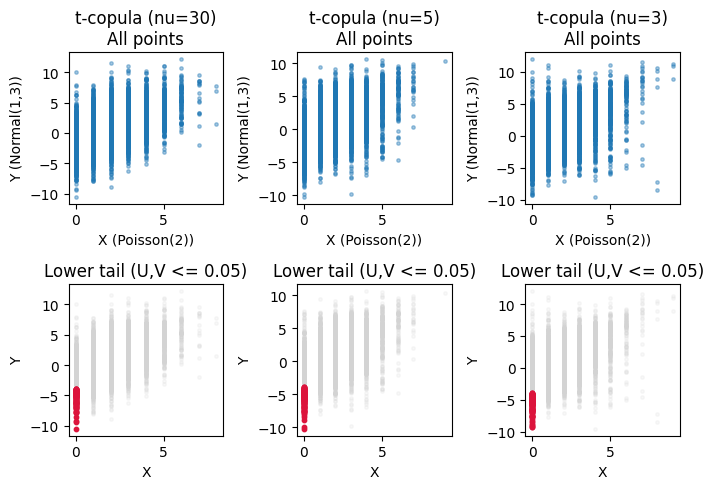

In [22]:
# 자유도값에 따른 꼬리 의존성 살펴보기

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import StudentTCopula

np.random.seed(42)

def sample_xy_tcopula(rho, nu, n=6000):
    corr = np.array([[1.0, rho],
                     [rho, 1.0]])
    cop = StudentTCopula(corr=corr, df=nu)
    uv = cop.rvs(n)                 # (U,V) ~ copula
    U = np.clip(uv[:, 0], 1e-12, 1-1e-12)
    V = np.clip(uv[:, 1], 1e-12, 1-1e-12)

    # Marginals (Sklar)
    X = poisson(mu=2).ppf(U).astype(int)
    Y = norm(loc=1, scale=3).ppf(V)
    return U, V, X, Y

rho = 0.5
nus = [30, 5, 3]   # nu가 작을수록 꼬리 의존성 ↑
q = 0.05           # 하단 5% 꼬리 강조

fig, axes = plt.subplots(2, len(nus), figsize=(7, 5), sharex=False, sharey=False)

for j, nu in enumerate(nus):
    U, V, X, Y = sample_xy_tcopula(rho, nu, n=6000)

    # (위) 전체 산점도
    axes[0, j].scatter(X, Y, s=6, alpha=0.4)
    axes[0, j].set_title(f"t-copula (nu={nu})\nAll points")
    axes[0, j].set_xlabel("X (Poisson(2))")
    axes[0, j].set_ylabel("Y (Normal(1,3))")

    # (아래) 좌측 꼬리만 강조: U<=q, V<=q
    mask_tail = (U <= q) & (V <= q)
    axes[1, j].scatter(X, Y, s=6, alpha=0.15, color="lightgray")
    axes[1, j].scatter(X[mask_tail], Y[mask_tail], s=10, color="crimson")
    axes[1, j].set_title(f"Lower tail (U,V <= {q})")
    axes[1, j].set_xlabel("X")
    axes[1, j].set_ylabel("Y")

plt.tight_layout()
plt.show()


In [24]:
# Clayton Copula 이용하기

import numpy as np
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import ClaytonCopula

# -----------------------------
# 1) Clayton copula 설정
#    theta > 0 일수록 양(+)의 하방 꼬리 의존성이 강해짐
# -----------------------------
theta = 2.0  # 예시값 (원하면 0.5, 1, 3 등으로 바꿔 비교 가능)
cop = ClaytonCopula(theta=theta)

# -----------------------------
# 2) Copula에서 (U, V) 샘플링 (Uniform(0,1))
# -----------------------------
N = 1000
uv = cop.rvs(N, random_state=42)          # shape (N, 2)

U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)   # ppf 안전장치
V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)

# -----------------------------
# 3) Sklar 변환: 주변분포로 매핑
# -----------------------------
X = poisson(mu=2).ppf(U).astype(int)      # X ~ Poisson(2)
Y = norm(loc=1, scale=3).ppf(V)           # Y ~ Normal(1, 3)

# -------------------------------------------------------
# 4) 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")
print("\n===== 상관관계(피어슨) =====")
print(pear_corr)
print("\n===== 상관관계(스피어만) =====")
print(spear_corr)



===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.623365
Y  0.623365  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.675049
Y  0.675049  1.000000


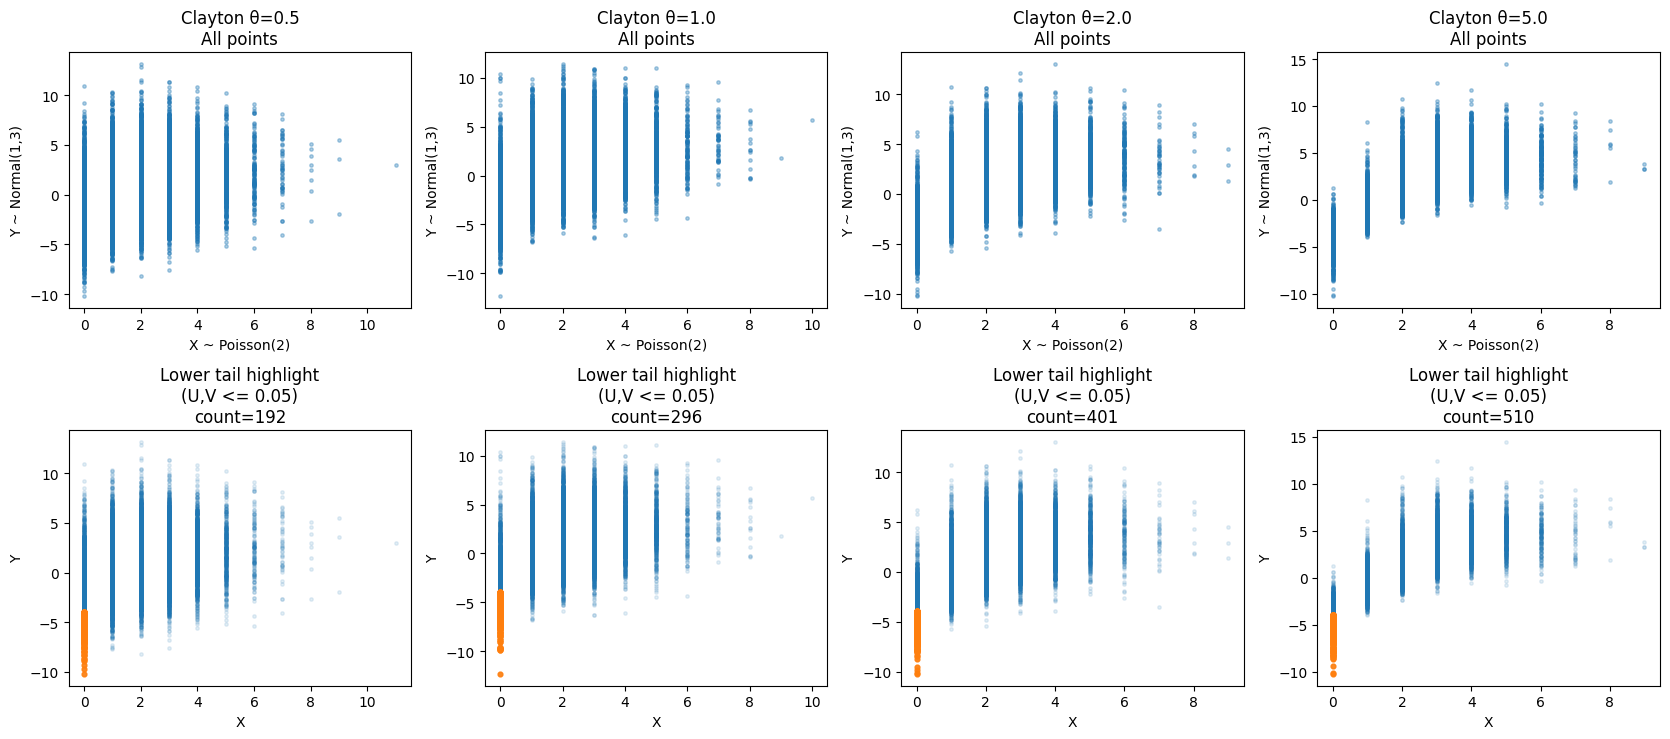

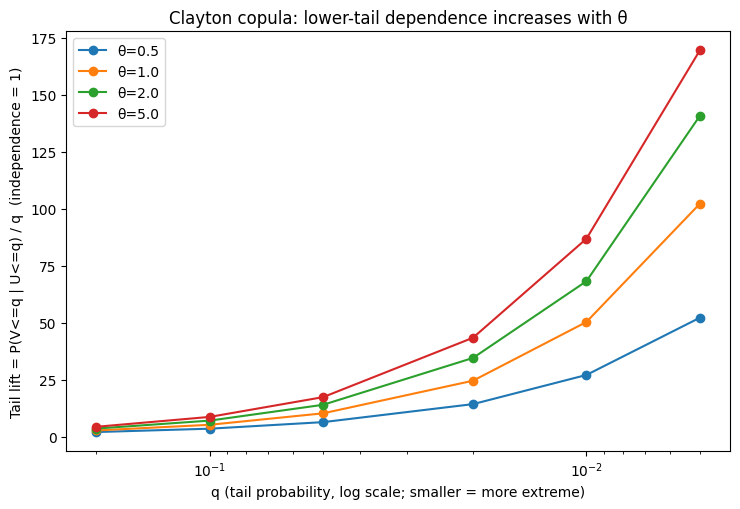

In [26]:
# theta 값 변경에 따른 꼬리 의존성 시각화

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import ClaytonCopula

def sample_xy_clayton(theta, n=8000, seed=0):
    rng = np.random.default_rng(seed)
    cop = ClaytonCopula(theta=theta)
    uv = cop.rvs(n, random_state=rng)
    U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)
    V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)
    X = poisson(mu=2).ppf(U).astype(int)
    Y = norm(loc=1, scale=3).ppf(V)
    return U, V, X, Y

thetas = [0.5, 1.0, 2.0, 5.0]   # theta ↑ => lower tail dependence ↑
q = 0.05                        # 하단 5% 꼬리 강조
n = 12000

# -------------------------
# Plot 1: 산점도(전체) + 하방 꼬리 강조
# -------------------------
fig, axes = plt.subplots(2, len(thetas), figsize=(4.2*len(thetas), 7.5))

for j, th in enumerate(thetas):
    U, V, X, Y = sample_xy_clayton(th, n=n, seed=100+j)

    # 전체 산점도
    axes[0, j].scatter(X, Y, s=6, alpha=0.35)
    axes[0, j].set_title(f"Clayton θ={th}\nAll points")
    axes[0, j].set_xlabel("X ~ Poisson(2)")
    axes[0, j].set_ylabel("Y ~ Normal(1,3)")

    # 하방 꼬리 동시 이벤트 강조
    mask = (U <= q) & (V <= q)
    axes[1, j].scatter(X, Y, s=6, alpha=0.12)            # 배경
    axes[1, j].scatter(X[mask], Y[mask], s=12, alpha=0.9) # 강조(기본 색)
    # 참고: matplotlib 기본 색 사용(색 지정 안함) 요구사항 준수
    axes[1, j].set_title(f"Lower tail highlight\n(U,V <= {q})\ncount={mask.sum()}")
    axes[1, j].set_xlabel("X")
    axes[1, j].set_ylabel("Y")

plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Tail lift 곡선 (θ별 비교)
# tail_lift(q) = P(V<=q | U<=q) / q, 독립이면 1
# -------------------------
qs = np.array([0.20, 0.10, 0.05, 0.02, 0.01, 0.005])

plt.figure(figsize=(7.5, 5.2))
for j, th in enumerate(thetas):
    U, V, _, _ = sample_xy_clayton(th, n=200000, seed=500+j)  # lift는 더 큰 표본이 안정적
    lifts = []
    for qq in qs:
        p_u = np.mean(U <= qq)
        p_uv = np.mean((U <= qq) & (V <= qq))
        cond = p_uv / p_u
        lifts.append(cond / qq)
    plt.plot(qs, lifts, marker='o', label=f"θ={th}")

plt.xscale("log")
plt.gca().invert_xaxis()  # 왼쪽으로 갈수록 더 극단(q 작음)
plt.xlabel("q (tail probability, log scale; smaller = more extreme)")
plt.ylabel("Tail lift = P(V<=q | U<=q) / q  (independence = 1)")
plt.title("Clayton copula: lower-tail dependence increases with θ")
plt.legend()
plt.tight_layout()
plt.show()



In [28]:
# Gumbel Copula 이용

import numpy as np
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import GumbelCopula

# -----------------------------
# 1) Gumbel copula 설정
#    theta >= 1, theta↑ => upper-tail dependence↑
# -----------------------------
theta = 2.0  # 예시 (1.0이면 독립)
cop = GumbelCopula(theta=theta)

# -----------------------------
# 2) Copula에서 (U, V) 샘플링 (Uniform(0,1))
# -----------------------------
N = 1000
uv = cop.rvs(N, random_state=42)

U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)  # ppf 안전장치
V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)

# -----------------------------
# 3) Sklar 변환: 주변분포로 매핑
# -----------------------------
X = poisson(mu=2).ppf(U).astype(int)     # X ~ Poisson(2)
Y = norm(loc=1, scale=3).ppf(V)          # Y ~ Normal(1, 3)

# -------------------------------------------------------
# 4) 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")
print("\n===== 상관관계(피어슨) =====")
print(pear_corr)
print("\n===== 상관관계(스피어만) =====")
print(spear_corr)



===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.704118
Y  0.704118  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.665248
Y  0.665248  1.000000


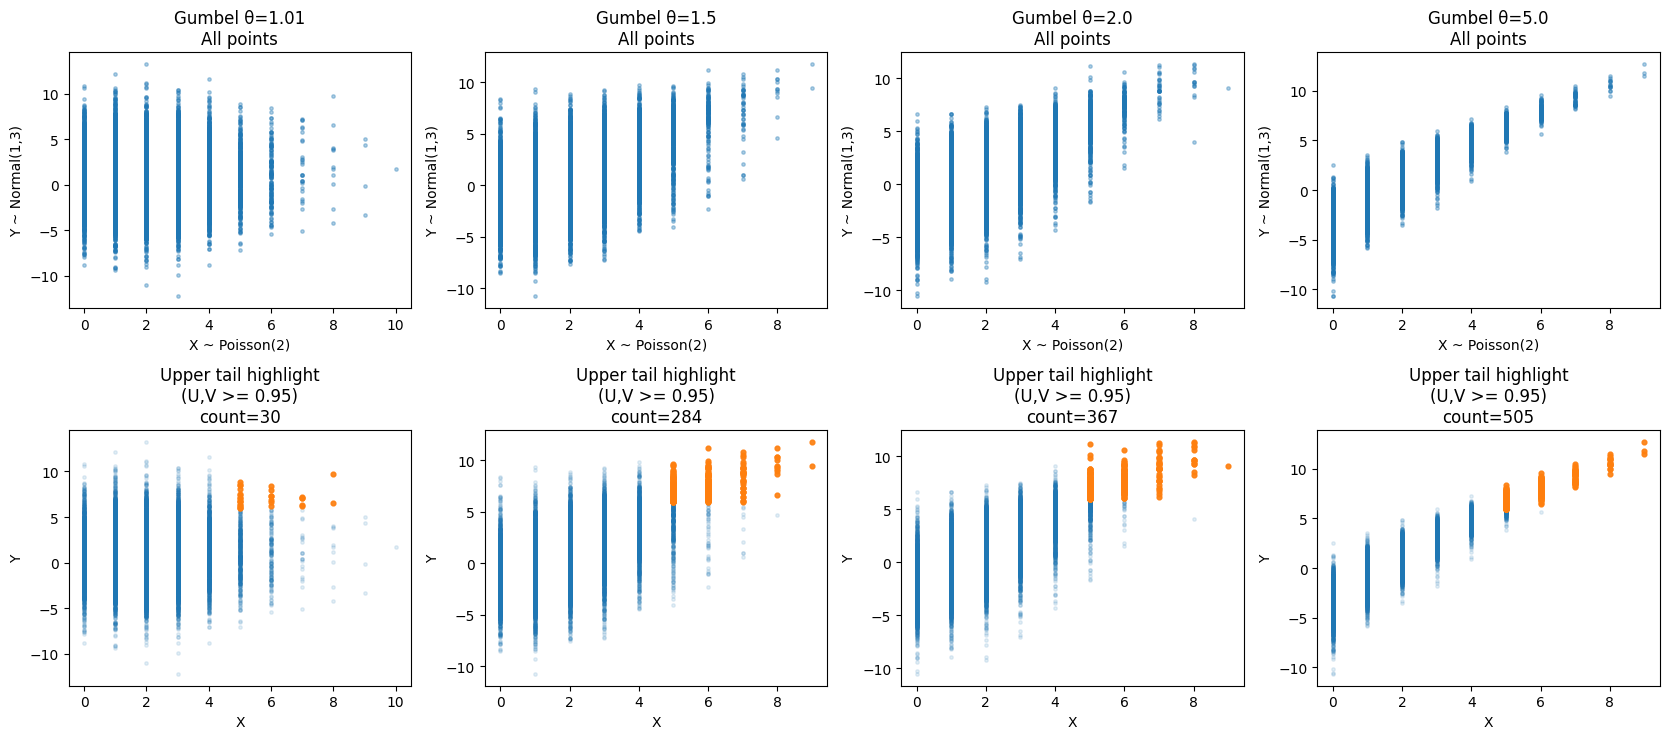

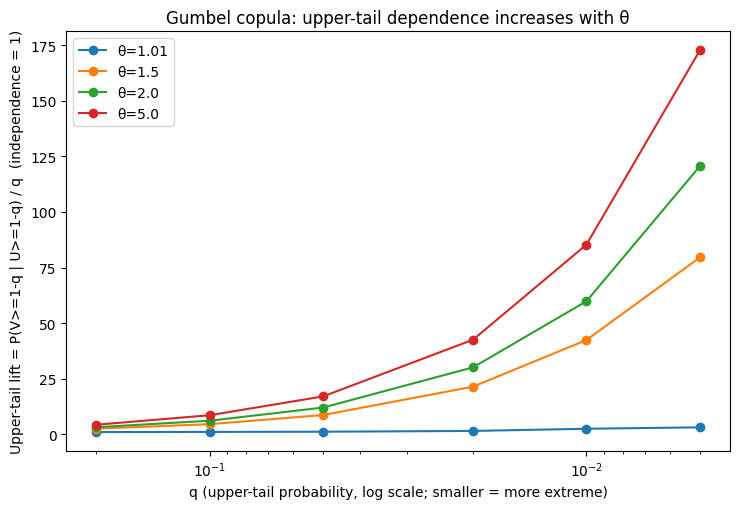

In [34]:
# theta값이 커질 수록 상방 꼬리 의존성이 강화되는 것 시각화 하기

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from statsmodels.distributions.copula.api import GumbelCopula

def sample_xy_gumbel(theta, n=12000, seed=0):
    rng = np.random.default_rng(seed)
    cop = GumbelCopula(theta=theta)  # statsmodels requires theta > 1
    uv = cop.rvs(n, random_state=rng)
    U = np.clip(uv[:, 0], 1e-12, 1 - 1e-12)
    V = np.clip(uv[:, 1], 1e-12, 1 - 1e-12)

    # (예제 마진) X~Poisson(2), Y~Normal(1,3)
    X = poisson(mu=2).ppf(U).astype(int)
    Y = norm(loc=1, scale=3).ppf(V)
    return U, V, X, Y

thetas = [1.01, 1.5, 2.0, 5.0]  # theta↑ => upper-tail dependence↑
q = 0.05                        # 상방 5% 꼬리 강조

# -------------------------
# 1) 산점도(전체) + 상방 꼬리 강조
# -------------------------
fig, axes = plt.subplots(2, len(thetas), figsize=(4.2*len(thetas), 7.5))

for j, th in enumerate(thetas):
    U, V, X, Y = sample_xy_gumbel(th, n=12000, seed=100+j)

    axes[0, j].scatter(X, Y, s=6, alpha=0.35)
    axes[0, j].set_title(f"Gumbel θ={th}\nAll points")
    axes[0, j].set_xlabel("X ~ Poisson(2)")
    axes[0, j].set_ylabel("Y ~ Normal(1,3)")

    mask = (U >= 1 - q) & (V >= 1 - q)  # upper-tail simultaneous
    axes[1, j].scatter(X, Y, s=6, alpha=0.12)
    axes[1, j].scatter(X[mask], Y[mask], s=12, alpha=0.9)
    axes[1, j].set_title(f"Upper tail highlight\n(U,V >= {1-q:.2f})\ncount={mask.sum()}")
    axes[1, j].set_xlabel("X")
    axes[1, j].set_ylabel("Y")

plt.tight_layout()
plt.show()

# -------------------------
# 2) Upper-tail lift 곡선 (θ별 비교)
#    lift_U(q)=P(V>=1-q | U>=1-q)/q, 독립이면 1
# -------------------------
qs = np.array([0.20, 0.10, 0.05, 0.02, 0.01, 0.005])

plt.figure(figsize=(7.5, 5.2))
for j, th in enumerate(thetas):
    U, V, _, _ = sample_xy_gumbel(th, n=250000, seed=500+j)  # lift는 큰 표본이 안정적
    lifts = []
    for qq in qs:
        p_u  = np.mean(U >= 1 - qq)
        p_uv = np.mean((U >= 1 - qq) & (V >= 1 - qq))
        cond = p_uv / p_u
        lifts.append(cond / qq)  # independence baseline = 1
    plt.plot(qs, lifts, marker='o', label=f"θ={th}")

plt.xscale("log")
plt.gca().invert_xaxis()  # 왼쪽으로 갈수록 더 극단(q 작음)
plt.xlabel("q (upper-tail probability, log scale; smaller = more extreme)")
plt.ylabel("Upper-tail lift = P(V>=1-q | U>=1-q) / q  (independence = 1)")
plt.title("Gumbel copula: upper-tail dependence increases with θ")
plt.legend()
plt.tight_layout()
plt.show()
